# Part 5: Homography + RANSAC

## 1. Find and Show the Matches:

In [1]:
import numpy as np
import scipy.linalg as linalg
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

First of all, read im01 and im02, then find all the SIFT keypoints and descriptors:

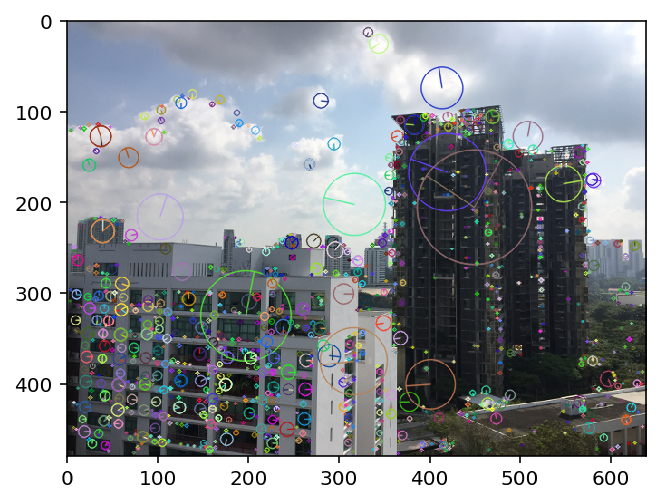

In [2]:
img1 = cv2.imread('im01.jpg')
img2 = cv2.imread('im02.jpg')
siftCreater = cv2.SIFT_create()

kps1, des1 = siftCreater.detectAndCompute(img1, None)
kps2, des2 = siftCreater.detectAndCompute(img2, None)

newImage1 = cv2.drawKeypoints(image=img1, keypoints=kps1, outImage=img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
newImage2 = cv2.drawKeypoints(image=img2, keypoints=kps2, outImage=img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(cv2.cvtColor(newImage1,cv2.COLOR_BGR2RGB), interpolation='none')
plt.imshow(cv2.cvtColor(newImage2,cv2.COLOR_BGR2RGB), interpolation='none')
plt.show()

Secondly, find all the matches based on SIFT keypoints and descriptors. The matches are found based on the 2-norm distance between members of kps1 and kps2.

In [4]:
# for each kp in kp1 of img1, find the match in kps2 of img2:
kpNum1 = des1.shape[0]
kpNum2 = des2.shape[0]
# print(kpNum1, kpNum2)

matches = np.zeros((kpNum1,5))
for i in range(0,kpNum1):
    minDist = np.linalg.norm(des1[i] - des2[0])
    matches[i][0] = kps1[i].pt[0]
    matches[i][1] = kps1[i].pt[1]
    matches[i][2] = kps2[0].pt[0]
    matches[i][3] = kps2[0].pt[1]
    matches[i][4] = minDist
    for j in range(1, kpNum2):
        newDist = np.linalg.norm(des1[i] - des2[j])
        if newDist < minDist:
            minDist = newDist
            matches[i][0] = kps1[i].pt[0]
            matches[i][1] = kps1[i].pt[1]
            matches[i][2] = kps2[j].pt[0]
            matches[i][3] = kps2[j].pt[1]
            matches[i][4] = minDist
# print(matches)

Now, draw the matching graph:

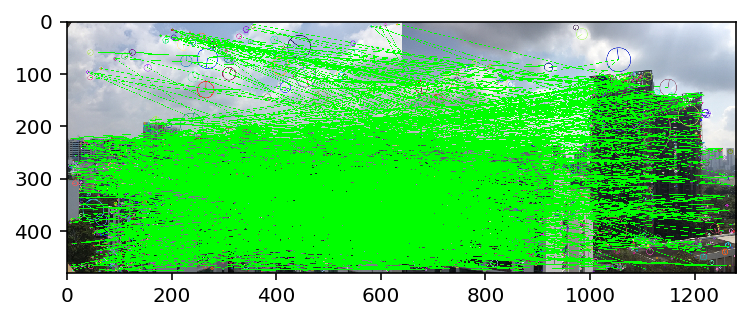

In [5]:
# prepare a new canvas
imgSizeY1 = img1.shape[0]
imgSizeX1 = img1.shape[1]
imgSizeY2 = img2.shape[0]
imgSizeX2 = img2.shape[1]
newImg = np.zeros((max(imgSizeY1, imgSizeY2), (imgSizeX1 + imgSizeX2), 3), dtype="uint8")
# paste the two images on the new canvas
newImg[0:imgSizeY1, 0:imgSizeX1] = img1
newImg[0:imgSizeY2, imgSizeX1:] = img2

# pt1 = (int(matches[0][0]), int(matches[0][1]))
# pt2 = ( (int(matches[0][2]) + imgSizeX1), int(matches[0][3]))
# cv2.line(newImg, pt1, pt2, (0, 255, 0), 1)

for i in range(0, kpNum1):
    pt1 = (int(matches[i][0]), int(matches[i][1]))
    pt2 = ( (int(matches[i][2]) + imgSizeX1), int(matches[i][3]))
    cv2.line(newImg, pt1, pt2, (0, 255, 0), 1)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.imshow(cv2.cvtColor(newImg,cv2.COLOR_BGR2RGB), interpolation='none')
plt.show()

## 2. Compute the Homography by Ransac
Now use RANSAC to compute the best homography. Two parameters to be set: the number of iterations T, and the parameter for inliner $\epsilon$

### 2.1. Supporting Functions:

In [9]:
# reduce the number of matches:
newMatchesSize = int(matches.shape[0]/14)
matches = matches[np.argsort(matches[:, 4])]
newMat = matches[0:newMatchesSize,0:5]

In [10]:
import random
# thres = 150
def selectRandomMatches(newMat):
    matchesSize = newMat.shape[0]
    randomMatPoses = random.sample(range(0, matchesSize),4)
    randomMat = []
    for i in randomMatPoses:
        kp1 = np.array([newMat[i][0], newMat[i][1], 1])
        kp2 = np.array([newMat[i][2], newMat[i][3], 1])  
        randomMat.append([kp1, kp2])
    
    return randomMat

In [11]:
def getHomographyOfRandomSize(points):
    # computes homography matrix of any sizes:
    length = len(points)
    A = np.zeros((length*2, 9))
    
    i=0
    while i < (length):
        j = i*2
        A[j][0:3] = np.array([points[i][0]])
        A[j][6:9] = np.array([-points[i][0][0]*points[i][1][0], -points[i][0][1]*points[i][1][0], -points[i][1][0]])
        A[j+1][3:6] = np.array([points[i][0]])
        A[j+1][6:9] = np.array([-points[i][0][0]*points[i][1][1], -points[i][0][1]*points[i][1][1], -points[i][1][1]])
        i+=1
#     print(A)
    U, D, Vt = linalg.svd(A)
    H = Vt[-1].reshape(3,3)
#     print(H)
    
    return H

In [12]:
def getRandomHomography(mat):
    # select 5 random matching points and computes the random homography
    # 1. select 5 random rows from the matching arry:
    randomMat = selectRandomMatches(mat)
    # 2. computes homography based on the 5 points and return:
    return getHomographyOfRandomSize(randomMat)    

In [13]:
# Set epsilon to be 50
def getInliners(H):
    # 1. count the inliners w.r.t. epsilon = 50:
    epsilon = 50
    # 2. initialize the list of inliners and error
    inliners = []
    totalErr = 0
    # 3. loop to search if there is a inliner in the matching pairs
    newMatSize = newMat.shape[0]
    for i in range(0, newMatSize):
        # 3.1.i get the kp1 in img1 and transforms:
        coord1 = np.array([newMat[i][0], newMat[i][1], 1])
#         coord1 = np.array([newMat[i][1], newMat[i][0], 1])
        transCoord1 = H.dot(coord1) # transforms by H
        transCoord1 = transCoord1/transCoord1[2] # normalization
        # 3.2. get the matching kp2 in img2 of that in img1
        coord2 = np.array([newMat[i][2], newMat[i][3], 1])
#         coord2 = np.array([newMat[i][3], newMat[i][2], 1])
        # 3.3. work out the distance between kp2 and H*kp1
        dist = np.linalg.norm(transCoord1 - coord2)
        # 3.4 updates the inliner list if the current pair is close enough: dist < epsilon
        if dist < epsilon:
            inliners.append([coord1, coord2])
            totalErr+=dist # work out the total error of the current list of inliners
    # 4. returns the inliners and the corresponding error:
    return inliners, totalErr

In [14]:
def ransac():
    # define the number of iterations:
    T = 7000
    # define the maximum set of inliners and best(smallest error)
    maxInliners = []
    maxInlinersNum = 0
    bestErr = 0
    # loop for T interations to find the best homography that most points agrees
    superH = np.zeros((3,3))
    for i in range(0, T):
#         print(i)
        # select a random homography:
        H = getRandomHomography(newMat)
        # count the inliners:
        inliners, err = getInliners(H)
        # update the best set of inliners and errors
        if (i == 0):
            superH = H
            bestErr = err
            maxInliners = inliners
        if (maxInlinersNum < len(inliners)) or (bestErr > err):
            superH = H
            maxInliners = inliners
            maxInlinersNum = len(inliners)
    # recompute the homography on all the inliners from the maximum inliners-set
    maxInlinersArr = np.zeros((maxInlinersNum, 4))
    for i in range(0, maxInlinersNum):
        maxInlinersArr[i,0:2] = np.array([maxInliners[i][0][0], maxInliners[i][0][1]])
        maxInlinersArr[i,2:4] = np.array([maxInliners[i][1][0], maxInliners[i][1][1]])
    
#     superH = getRandomHomography(maxInlinersArr)
#     print(maxInliners)
    return maxInliners, superH

### 2.2. Find the Best Set of Inliners and Draw Matches

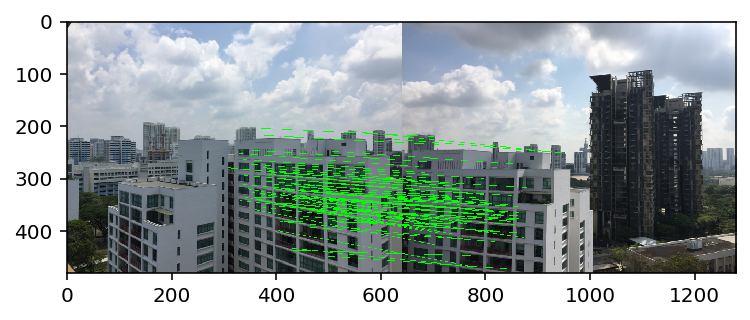

In [15]:
img1 = cv2.imread('im01.jpg')
img2 = cv2.imread('im02.jpg')
# prepare a new canvas
imgSizeY1 = img1.shape[0]
imgSizeX1 = img1.shape[1]
imgSizeY2 = img2.shape[0]
imgSizeX2 = img2.shape[1]
newImg = np.zeros((max(imgSizeY1, imgSizeY2), (imgSizeX1 + imgSizeX2), 3), dtype="uint8")

# paste the two images on the new canvas
newImg[0:imgSizeY1, 0:imgSizeX1] = img1
newImg[0:imgSizeY2, imgSizeX1:] = img2

# get the maximum set of inliners and best homography(superH) on all the inliners from ransac()
maxInliners, superH = ransac()
# draw the matching graph:
length = len(maxInliners)
i=0
while(i < (length)):
    pt1 = (int(maxInliners[i][0][0]), int(maxInliners[i][0][1]))
    pt2 = ((int(maxInliners[i][1][0]) + imgSizeX1), int(maxInliners[i][1][1]))
    cv2.line(newImg, pt1, pt2, (0, 255, 0), 1)
    i+=1
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.imshow(cv2.cvtColor(newImg,cv2.COLOR_BGR2RGB), interpolation='none')
plt.show()

### 2.3. Stitch the Images Together

#### 2.3.1 Supporting Functions:

In [18]:
def getMinMax(array, maxXLimit, maxYLimit, minXLimit, minYLimit):
    size = array.shape[1]
    # find minX and maxX:
    xSortedArr = array[:, array[0, :].argsort()]

    i = 0
    minX = xSortedArr[0, i]
    while(i < size-1 and xSortedArr[0, i] <= minXLimit):
        i+=1
        minX = xSortedArr[0, i]
    
    j = size-1
    maxX= xSortedArr[0, j]
    while(j > 1 and xSortedArr[0, j] >= maxXLimit):
        j-=1
        maxX = xSortedArr[0, j]
    
    # find minY and maxY:
    ySortedArr = array[:, array[1, :].argsort()]
#     print(ySortedArr)
    i = 0    
    minY = ySortedArr[1, i]
    while(i < size-1 and ySortedArr[1, i] <= minYLimit):
        i+=1
        minY = ySortedArr[1, i]
    
    j = size-1
    maxY= ySortedArr[1, j]
    while(j > 1 and ySortedArr[1, j] >= maxYLimit):
        j-=1
        maxY = ySortedArr[1, j]
        
    return minX, minY, maxX, maxY

def computeHomographyAndConcat1(img1, img2, H):
    imgSizeX1 = img1.shape[0]
    imgSizeY1 = img1.shape[1]
    imgSizeX2 = img2.shape[0]
    imgSizeY2 = img2.shape[1]
    
    maxXLimit = imgSizeX1
    maxYLimit = imgSizeY1
    minXLimit = -maxXLimit
    minYLimit = -maxYLimit

    i, cnt= 0, 0
    step = 0.5
    newPos = np.zeros((3,int(imgSizeX1/step)*int(imgSizeY1/step)))
    while(i < imgSizeY1):
        j=0
        while(j < imgSizeX1):
            newPos[:,cnt] = H.dot(np.array([i,j,1]))
            newPos[:,cnt] = newPos[:,cnt]/newPos[2,cnt]
            newPos[0,cnt] = newPos[0,cnt]
            newPos[1,cnt] = newPos[1,cnt]
            j+=step
            cnt+=1
        i+=step
    # get the minimum and maximum poses of the orgPoses
    minX, minY, maxX, maxY = getMinMax(newPos, maxXLimit, maxYLimit, minXLimit, minYLimit)
    print(minX, minY, maxX, maxY)
    # shifting img1, shifting the maximum size of the canvas
    shiftX = 0
    shiftY = 0
    if minX < 0:
        newPos[0,:] += abs(minX)
        shiftX = int(abs(minX))
        maxX += abs(minX)
    if minY < 0:
        newPos[1,:] += abs(minY)
        shiftY = int(abs(minY))
        maxY += abs(minY)
    # get the new canvas
    newSizeX = int(maxX)+imgSizeX2
    newSizeY = int(maxY)+imgSizeY2
    newImg = np.zeros((newSizeX, newSizeY, 3),np.uint8)
    # prepare img2 on the new canvas
    print(imgSizeY2, imgSizeX2)
    for i in range(0,int(imgSizeX2)):
        for j in range(0,int(imgSizeY2)):
            newImg[i+shiftY][j+shiftX] = img2[i][j]
             
    i, cnt= 0, 0
    step = 0.5
    while(i < imgSizeY1):
        j=0
        while(j < imgSizeX1):
            newPosX = int(newPos[0][cnt]) # round the indexes to integer
            newPosY = int(newPos[1][cnt])
            if((newPosX >= 0 and newPosX < newSizeY) and (newPosY >= 0 and newPosY < newSizeX)):
                newImg[newPosY][newPosX] = img1[int(j)][int(i)]
            j+=step
            cnt+=1
        i+=step
    
    # Draw img
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.imshow(newImg/255)
    plt.show()
    return newImg

#### 2.3.2. Draw the Stitched Image:

-479.99746424647435 -260.24666741821085 348.218857297563 639.9916615072309
640 480


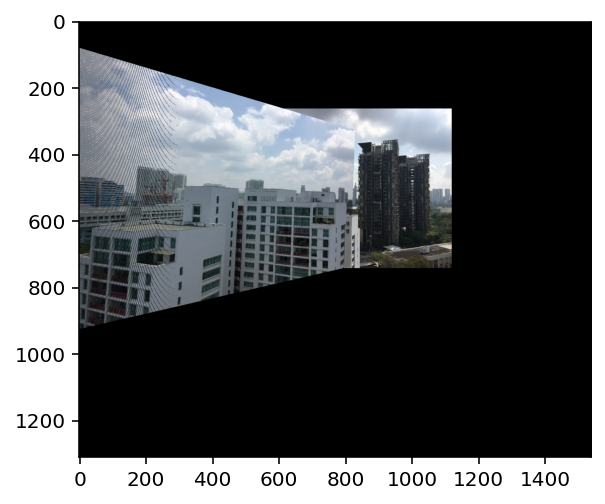

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [20]:
# Testing block
img1 = cv2.imread('im01.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('im02.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
computeHomographyAndConcat1(img1, img2, superH)